In [1]:
from importlib import reload
from astropy import units as u
from astropy import constants as const

import pandas as pd
import pandas as pandas
import numpy as np
import matplotlib.pyplot as plt

from matplotlib import ticker
import matplotlib.colors
import matplotlib.ticker as mticker

from scipy.interpolate import UnivariateSpline

from src import astro530

In [2]:
saha_LTE = astro530.saha_LTE
Pe_calc = astro530.Pe_calc

In [3]:
astro530 = reload(astro530)

In [4]:
partition = astro530.partition
find_Abundance = astro530.find_Abundance

In [5]:
saha_LTE(species="Na",temp=6420*u.K,Pe=55*u.Ba)

1423.708485837703

In [12]:
m_Na

<Quantity 3.8175295e-23 g>

In [16]:
from scipy.special import wofz
m_Na = 22.9897*u.g/u.mol/const.N_A
def Voigt(a,u):
    return np.real(wofz(u+1j*a))
def Voigt_wrapper_Na(nu, T=5000*u.K, Pg=300*u.dyn/u.cm**2, uturb=0*u.km/u.s, n_e = 10**6/u.cm**3,ideal_gas = False):
    c = const.c
    try: 
        nu = nu.to(u.Hz)
        T = T.to(u.K)
        Pg = Pg.to(u.Ba)
        uturb = uturb.to(u.cm/u.s)
    except: 
        nu = nu*u.Hz
        T = T *u.K
        Pg = Pg*u.Ba
        uturb = uturb*u.cm/u.s
    nu0 = (np.array([5889.95,5895.924])*u.Angstrom).to(u.Hz,equivalencies=u.spectral())
    
    delta_nu = nu0/c*np.sqrt((2*const.k_B*T/m_Na)+uturb**2)
    
    if ideal_gas:
        Pe = n_e*const.k_B*T
    else:
        Pe = Pe_calc(Pg=Pg,T=T)
    try:
        nu[0]
        single_nu = False
    except:
        single_nu = True
        
    if single_nu:
        gamma = lorentz_Na(nu, Pe=Pe,Pg=Pg,T=T)
        #eta = (nu-nu0)*c/nu0
        print("delta_nu =",delta_nu.cgs)
        u0 = (nu-nu0)/delta_nu
        a0 = gamma/(4*np.pi*delta_nu)
        print("u =",u0.cgs)
        print("a =",a0.cgs)
        v_p = Voigt(a0,u0)/(np.sqrt(np.pi)*delta_nu)
        delta_l = c*delta_nu/nu0**2
        print("H:",Voigt(a0,u0))
        print("ϕ [cm^-1]:",(v_p*delta_nu/delta_l).cgs)
        return v_p.cgs
    else: 
        V_list = []
        for v in nu:
            gamma = lorentz_Na(v, Pe=Pe, Pg=Pg,T=T)
            #eta = (v-nu0)*c/nu0
        
            u0 = (v-nu0)/delta_nu
            a0 = gamma/(4*np.pi*delta_nu)
            Vo = Voigt(a0,u0)
            
            V_list.append(Vo.value)
        V_arr = np.array(V_list)*Vo.unit
        #return V_arr.cgs
        V0 = V_arr[:,0]/(np.sqrt(np.pi)*delta_nu[0])
        V1 = V_arr[:,1]/(np.sqrt(np.pi)*delta_nu[1])
        return (np.array([V0,V1]).T*V0.unit).cgs
def lorentz_Na(nu, Pe = 100*u.Ba, Pg = 300*u.Ba, T = 5000*u.K,print_bool=False):
    nu0 = (np.array([5889.95,5895.924])*u.Angstrom).to(u.Hz,equivalencies=u.spectral())
    
    # Radiation
    yrad = np.array([6.16,6.14])*10**7*u.Hz
    
    # Gamma4
    logC4 = np.array([-15.17,-15.33])
    logy4 = 19+2/3*logC4+np.log10(Pe/(1*u.Ba))-5/6 * np.log10(T/(1*u.K))
    
    # Gamma6
    I = 5.17*u.eV
    chi_n = 0*u.eV#2.1*u.eV
    chi_nu = const.h*nu0#nu
#     print(I-chi_n-chi_nu)
#     print(I-chi_n)
    
    logC6 = np.log10(0.3)-30+np.log10(((1/(I-chi_n-chi_nu)**2-1/(I-chi_n)**2).to(1/u.eV**2)).value)
    #print(logC6)
    #logy6 = 20+2/5*np.log10(C6.cgs.value)+np.log(Pg/u.Ba)-7/10*np.log10(T/u.K)
    logy6 = 20+2/5*logC6+np.log10(Pg/u.Ba)-7/10*np.log10(T/u.K)
    
    y4 = 10**logy4
    y6 = 10**logy6
    
#     print("logy4 =",logy4)
#     print("logy6 =",logy6)
    if print_bool:
        print("gamma_r:",yrad)
        print("gamma_tot:",yrad + (y4+y6)*u.Hz)
    
    return yrad + (y4+y6)*u.Hz
def mono_line_ext_NA(nu, T=5000*u.K, Pg=300*u.dyn/u.cm**2, uturb=0*u.km/u.s,print_bool = False,**kwargs):
    c = const.c
    h = const.h
    try: 
        nu = nu.to(u.Hz)
        T = T.to(u.K)
        Pg = Pg.to(u.Ba)
        uturb = uturb.to(u.cm/u.s)
    except: 
        nu = nu*u.Hz
        T = T *u.K
        Pg = Pg*u.Ba
        uturb = uturb*u.cm/u.s
    l0 = np.array([5889.95,5895.924])*u.Angstrom
    nu0 = (l0).to(u.Hz,equivalencies=u.spectral())
    Aul = np.array([6.16,6.14])*10**7*u.Hz
    gu = np.array([4,2])
    gl = np.array([2,2])
    Bul = Aul*c**2/(2*h*nu0**3)
    Blu = gu/gl*Bul
    delta_nu = nu0/c*np.sqrt((2*const.k_B*T/m_Na)+uturb**2)
    
   
    
    #print(Blu.cgs)
    ϕ = Voigt_wrapper_Na(nu, T=T, Pg=Pg, uturb=uturb,**kwargs)
    print("Voigt:",ϕ)
    #print("Voigt2:",ϕ*np.sqrt(np.pi)*delta_nu)
    #print(np.sqrt(np.pi)*delta_nu*ϕ)
    print("Δλ_D:", (c*delta_nu/(nu0)**2).to(u.cm))
    print("Δn_D:",(1/(c*delta_nu/(nu0)**2)).to(1/u.cm))
    f = 1.884e-15*l0**2 *gu/gl*Aul#const.m_e*const.c**3/(2*np.pi*const.e**2*((np.array([5890,5896]).AA).to(u.Hz,equivalencies=u.spectral()))**2*np.array([2,1]))*Aul
    e = 4.8032e-10*u.cm**(3/2)*u.g**(1/2)*u.s**(-1)
    #print("f:",f)
    print("f:",f.cgs)
    print("ϕ:",ϕ.cgs)
    
#     try:
#         sig_0 = np.pi*e**2*f[0]/(const.m_e*const.c)*ϕ[:,0]
#         sig_1 = np.pi*e**2*f[1]/(const.m_e*const.c)*ϕ[:,1]
#         return (np.array([sig_0,sig_1]).T*sig_0.unit).cgs
#     except:
#         return (h*nu*Blu*ϕ).cgs
    try:
        sig_0 = h*nu/(4*np.pi)*Blu[0]*ϕ[:,0]
        sig_1 = h*nu/(4*np.pi)*Blu[1]*ϕ[:,1]
        return (np.array([sig_0,sig_1]).T*sig_0.unit).cgs
    except:
        return (h*nu*Blu*ϕ/(4*np.pi)).cgs


In [7]:
(const.c*(const.e.esu)**2).cgs

<Quantity 6.9164445e-09 erg St>

In [8]:
const.m_p.cgs

<Quantity 1.67262192e-24 g>

In [9]:
lorentz_Na((5890*u.Angstrom).to(u.Hz,equivalencies=u.spectral()), T=6420*u.K, Pe=57*u.Ba, Pg=1.137e5*u.Ba)

<Quantity [5.30262539e+09, 5.29153264e+09] Hz>

In [10]:
Voigt_wrapper_Na((np.array([5800])*u.Angstrom).to(u.Hz,equivalencies=u.spectral()), T=6420*u.K, Pg=1.137e5*u.Ba)


<Quantity [[2.15537038e-18, 1.89517990e-18]] s>

In [17]:
mono_line_ext_NA((5889.95*u.Angstrom).to(u.Hz,equivalencies=u.spectral()),T=6420*u.K,Pg=1.137e5*u.Ba,uturb=1.6*u.km/u.s)

delta_nu = [4.55687132e+09 4.55225411e+09] 1 / s
u = [  0.        113.2911382]
a = [0.09259114 0.09249322]
H: [9.03532876e-01 4.06624534e-06]
ϕ [cm^-1]: [9.66717866e+08 4.34619388e+03] 1 / cm
Voigt: [1.11867069e-10 5.03955450e-16] s
Δλ_D: [5.27313971e-10 5.27848810e-10] cm
Δn_D: [1.89640338e+09 1.89448187e+09] 1 / cm
f: [8.05220499e-16 4.02117546e-16] cm2 / s
ϕ: [1.11867069e-10 5.03955450e-16] s


<Quantity [1.90237584e-12, 4.28415011e-18] cm2>

In [12]:
(5800*u.Angstrom).to(u.Hz,equivalencies=u.spectral())

<Quantity 5.16883548e+14 Hz>

In [13]:
nu_arr = (np.linspace(5840,5940,2000)*u.Angstrom).to(u.Hz,equivalencies=u.spectral())
lam_arr = nu_arr.to(u.AA,equivalencies=u.spectral())
sig = mono_line_ext_NA(nu_arr,T=6420*u.K,Pg=1.137e5*u.Ba,uturb=0*u.km/u.s)


Voigt: [[7.08636119e-18 5.65299365e-18]
 [7.10069821e-18 5.66321767e-18]
 [7.11507854e-18 5.67346928e-18]
 ...
 [7.33089056e-18 9.45752074e-18]
 [7.31635199e-18 9.43619943e-18]
 [7.30185687e-18 9.41495049e-18]] s
Δλ_D: [4.23373682e-10 4.23803097e-10] cm
Δn_D: [2.36197960e+09 2.35958634e+09] 1 / cm
f: [8.05220499e-16 4.02117546e-16] cm2 / s
ϕ: [[7.08636119e-18 5.65299365e-18]
 [7.10069821e-18 5.66321767e-18]
 [7.11507854e-18 5.67346928e-18]
 ...
 [7.33089056e-18 9.45752074e-18]
 [7.31635199e-18 9.43619943e-18]
 [7.30185687e-18 9.41495049e-18]] s


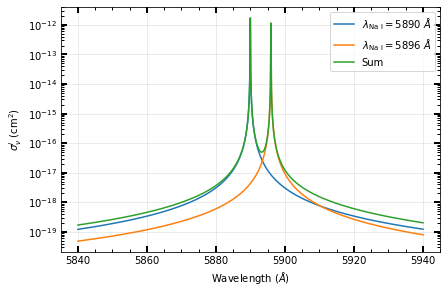

In [14]:
fig, ax = plt.subplots(figsize = (6,4), nrows = 1, ncols = 1)
fig.tight_layout(h_pad=-.5)

    
ax.yaxis.set_ticks_position('both')
ax.xaxis.set_ticks_position('both')
ax.minorticks_on()
ax.grid(True,alpha=.3)

ax.tick_params(direction='in', axis='both',which='minor',length=3,width=1)#,labelsize=8)
ax.tick_params(direction='in',axis='both',which='major',length=6,width=2)#,labelsize=8)

ax.set_yscale("log")

ax.plot(lam_arr,sig[:,0],label=r"$\lambda_{\mathrm{Na~I}}=5890~\AA$")
ax.plot(lam_arr,sig[:,1],label=r"$\lambda_{\mathrm{Na~I}}=5896~\AA$")
ax.plot(lam_arr,np.sum(sig,axis=1), label = "Sum")

ax.set_ylabel(r"$\sigma^l_\nu~$(cm$^2$)")
ax.set_xlabel(r"Wavelength ($\AA$)")

ax.legend()

output_file = "plots/20.pdf"

fig.savefig(output_file,bbox_inches='tight')

Voigt: [[7.08636119e-18 5.65299365e-18]
 [7.10069821e-18 5.66321767e-18]
 [7.11507854e-18 5.67346928e-18]
 ...
 [7.33089056e-18 9.45752074e-18]
 [7.31635199e-18 9.43619943e-18]
 [7.30185687e-18 9.41495049e-18]] s
Δλ_D: [4.23373682e-10 4.23803097e-10] cm
Δn_D: [2.36197960e+09 2.35958634e+09] 1 / cm
f: [8.05220499e-16 4.02117546e-16] cm2 / s
ϕ: [[7.08636119e-18 5.65299365e-18]
 [7.10069821e-18 5.66321767e-18]
 [7.11507854e-18 5.67346928e-18]
 ...
 [7.33089056e-18 9.45752074e-18]
 [7.31635199e-18 9.43619943e-18]
 [7.30185687e-18 9.41495049e-18]] s
Voigt: [[7.10258998e-18 5.66331364e-18]
 [7.11699286e-18 5.67357509e-18]
 [7.13143938e-18 5.68386428e-18]
 ...
 [7.34826097e-18 9.48646554e-18]
 [7.33365344e-18 9.46501353e-18]
 [7.31908970e-18 9.44363464e-18]] s
Δλ_D: [1.96513196e-08 1.96712513e-08] cm
Δn_D: [50887167.91164073 50835606.87708464] 1 / cm
f: [8.05220499e-16 4.02117546e-16] cm2 / s
ϕ: [[7.10258998e-18 5.66331364e-18]
 [7.11699286e-18 5.67357509e-18]
 [7.13143938e-18 5.68386428e-18]

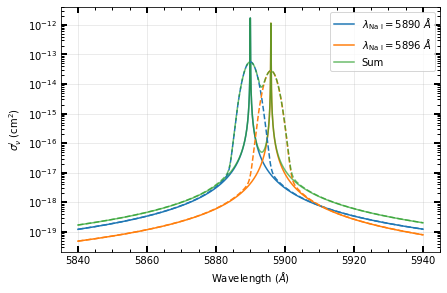

In [15]:
fig, ax = plt.subplots(figsize = (6,4), nrows = 1, ncols = 1)
fig.tight_layout(h_pad=-.5)
utr = [0,100]
ls_a = ["-","--"]

ax.yaxis.set_ticks_position('both')
ax.xaxis.set_ticks_position('both')
ax.minorticks_on()
ax.grid(True,alpha=.3)

ax.tick_params(direction='in', axis='both',which='minor',length=3,width=1)#,labelsize=8)
ax.tick_params(direction='in',axis='both',which='major',length=6,width=2)#,labelsize=8)

ax.set_yscale("log")

sig = mono_line_ext_NA(nu_arr,T=6420*u.K,Pg=1.137e5*u.Ba,uturb=utr[0]*u.km/u.s)

ax.plot(lam_arr,sig[:,0],label=r"$\lambda_{\mathrm{Na~I}}=5890~\AA$",ls = "-",c="C0")
ax.plot(lam_arr,sig[:,1],label=r"$\lambda_{\mathrm{Na~I}}=5896~\AA$",ls = "-",c="C1")
ax.plot(lam_arr,np.sum(sig,axis=1), label = "Sum",ls = ls_a[0],c="C2",alpha=.7)

sig = mono_line_ext_NA(nu_arr,T=6420*u.K,Pg=1.137e5*u.Ba,uturb=utr[1]*u.km/u.s)

ax.plot(lam_arr,sig[:,0],ls = "--",c="C0")
ax.plot(lam_arr,sig[:,1],ls = "--",c="C1")
ax.plot(lam_arr,np.sum(sig,axis=1),ls = ls_a[1],c="C2",alpha=.7)

ax.set_ylabel(r"$\sigma^l_\nu~$(cm$^2$)")
ax.set_xlabel(r"Wavelength ($\AA$)")

ax.legend()

output_file = "plots/20b.pdf"

fig.savefig(output_file,bbox_inches='tight')

In [16]:
mono_line_ext_NA((np.array([5890])*u.Angstrom).to(u.Hz,equivalencies=u.spectral()),T=6420*u.K,Pg=1.13e5*u.Ba,uturb=0*u.km/u.s)/(22.9897*u.g/u.mol/const.N_A)


Voigt: [[4.15575091e-11 5.09373916e-16]] s
Δλ_D: [4.23373682e-10 4.23803097e-10] cm
Δn_D: [2.36197960e+09 2.35958634e+09] 1 / cm
f: [8.05220499e-16 4.02117546e-16] cm2 / s
ϕ: [[4.15575091e-11 5.09373916e-16]] s


<Quantity [[1.85121766e+10, 1.13428750e+05]] cm2 / g>

In [17]:
def line_opacity_Na(nu,T=5000*u.K,Pg=100*u.Ba,uturb=0*u.km/u.s,rho = 10*u.g/u.cm**3,nH = 10**6/u.cm**3,print_bool=True,**kwargs):
    σ = mono_line_ext_NA(nu,T=T,Pg=Pg,uturb=uturb,**kwargs)
    A = find_Abundance("Na")
    Pe = 57*u.Ba#Pe_calc(T=T,Pg=Pg)
    fe = .86#2/partition(species="Na",temp=T.value)
    fi = 6.52e-4#1/(1+saha_LTE(species="Na",temp=T,Pe = Pe))
    spectral_emission = .9777#(1-np.exp(-const.h*(np.array([5890,5896])*u.Angstrom).to(u.Hz,equivalencies=u.spectral())/(const.k_B*T)))
    
    if print_bool:
        print("fe =",fe)
        print("fi =",fi)
        print("SEF =",spectral_emission)
        print("σ =",σ)    
    try:
        kappa_list = []
        for s in σ:
            kappa_list.append(s*A*nH/rho*fi*fe*spectral_emission)
        return np.array(kappa_list)*kappa_list[0].unit
    
    except:
        return σ*A*nH/rho*fi*fe*spectral_emission

In [18]:
line_opacity_Na((5889.95*u.Angstrom).to(u.Hz,equivalencies=u.spectral()),
                T=6420*u.K,Pg=1.137e5*u.Ba,rho=2.727e-7*u.g/u.cm**3,nH=1.166e17/u.cm**3,uturb=1.6*u.km/u.s)#,print_bool=True)

delta_nu = [4.55687132e+09 4.55225411e+09] 1 / s
u = [  0.        113.2911382]
a = [0.09259114 0.09249322]
ϕ [cm^-1]: [9.66717866e+08 4.34619388e+03] 1 / cm
Voigt: [1.11867069e-10 5.03955450e-16] s
Δλ_D: [5.27313971e-10 5.27848810e-10] cm
Δn_D: [1.89640338e+09 1.89448187e+09] 1 / cm
f: [8.05220499e-16 4.02117546e-16] cm2 / s
ϕ: [1.11867069e-10 5.03955450e-16] s
fe = 0.86
fi = 0.000652
SEF = 0.9777
σ = [1.90237584e-12 4.28415011e-18] cm2


<Quantity [9.54278568e+02, 2.14903519e-03] cm2 / g>

In [19]:
line_opacity_Na((np.array([5889.95,5893,5895.924])*u.Angstrom).to(u.Hz,equivalencies=u.spectral()),
                T=6420*u.K,Pg=1.137e5*u.Ba,rho=2.727e-7*u.g/u.cm**3,nH=1.166e17/u.cm**3,uturb=1.6*u.km/u.s,print_bool=False)

Voigt: [[1.11867069e-10 5.03955450e-16]
 [1.93613321e-15 2.10658037e-15]
 [5.05000736e-16 1.11992195e-10]] s
Δλ_D: [5.27313971e-10 5.27848810e-10] cm
Δn_D: [1.89640338e+09 1.89448187e+09] 1 / cm
f: [8.05220499e-16 4.02117546e-16] cm2 / s
ϕ: [[1.11867069e-10 5.03955450e-16]
 [1.93613321e-15 2.10658037e-15]
 [5.05000736e-16 1.11992195e-10]] s


<Quantity [[9.54278568e+02, 2.14903519e-03],
           [1.65075763e-02, 8.97851644e-03],
           [4.30352822e-03, 4.77088415e+02]] cm2 / g>

In [20]:
kl = line_opacity_Na(nu_arr,T=6420*u.K,Pg=1.137e5*u.Ba,rho=2.727e-7*u.g/u.cm**3,nH=1.166e17/u.cm**3,uturb=1.6*u.km/u.s)

Voigt: [[7.08636533e-18 5.65299628e-18]
 [7.10070237e-18 5.66322031e-18]
 [7.11508271e-18 5.67347193e-18]
 ...
 [7.33089499e-18 9.45752811e-18]
 [7.31635640e-18 9.43620677e-18]
 [7.30186127e-18 9.41495780e-18]] s
Δλ_D: [5.27313971e-10 5.27848810e-10] cm
Δn_D: [1.89640338e+09 1.89448187e+09] 1 / cm
f: [8.05220499e-16 4.02117546e-16] cm2 / s
ϕ: [[7.08636533e-18 5.65299628e-18]
 [7.10070237e-18 5.66322031e-18]
 [7.11508271e-18 5.67347193e-18]
 ...
 [7.33089499e-18 9.45752811e-18]
 [7.31635640e-18 9.43620677e-18]
 [7.30186127e-18 9.41495780e-18]] s
fe = 0.86
fi = 0.000652
SEF = 0.9777
σ = [[1.21539197e-19 4.84674303e-20]
 [1.21784050e-19 4.85546728e-20]
 [1.22029642e-19 4.86421503e-20]
 ...
 [1.23618520e-19 7.97228200e-20]
 [1.23372322e-19 7.95424205e-20]
 [1.23126860e-19 7.93626342e-20]] cm2


In [21]:
Pe_val = Pe_calc(T=6420*u.K,Pg=1.137e5*u.Ba)
print("Pe =",Pe_val)
SJM = astro530.abundance_mass()
k_t = astro530.k_cont(Pe=Pe_val,T=6420*u.K,wavelength=lam_arr,Pg=1.137e5*u.Ba)
k_A = astro530.k_cont(Pe=Pe_val,T=6420*u.K,wavelength=[5890,5896]*u.AA,Pg=1.137e5*u.Ba)
kHnbf = astro530.k_Hnbf(Pe=Pe_val,T=6420*u.K,wavelength=[5890,5896]*u.AA,stim_em_bool=True)/SJM
kHnff = astro530.k_Hnff(Pe=Pe_val,T=6420*u.K,wavelength=[5890,5896]*u.AA)/SJM
kHbf = astro530.k_Hbf(T=6420*u.K,wavelength=[5890,5896]*u.AA,stim_em_bool=True)/SJM
kHff = astro530.k_Hff(T=6420*u.K,wavelength=[5890,5896]*u.AA,stim_em_bool=True)/SJM
ke = astro530.k_e(Pe=Pe_val,Pg=1.137e5*u.Ba,species="all")/SJM
print("k_total =", k_A)
print("k_Hnbf =", kHnbf)
print("k_Hnff =", kHnff)
print("k_Hbf =", kHbf)
print("k_Hff =", kHff)
print("k_e =", ke)

Pe = 55.94020381510115 dyn / cm2
k_total = [0.76985895 0.77050992] cm2 / g
k_Hnbf = [0.7065048  0.70702354] cm2 / g
k_Hnff = [0.04981066 0.04990463] cm2 / g
k_Hbf = [0.01294243 0.01297936] cm2 / g
k_Hff = [0.00044449 0.00044582] cm2 / g
k_e = 0.00015657274298840808 cm2 / g


In [22]:
k_A = astro530.k_cont(Pe=Pe_val,T=6420*u.K,wavelength=lam_arr,Pg=1.137e5*u.Ba)
kHnbf = astro530.k_Hnbf(Pe=Pe_val,T=6420*u.K,wavelength=lam_arr,stim_em_bool=True)/SJM
kHnff = astro530.k_Hnff(Pe=Pe_val,T=6420*u.K,wavelength=lam_arr)/SJM
kHbf = astro530.k_Hbf(T=6420*u.K,wavelength=lam_arr,stim_em_bool=True)/SJM
kHff = astro530.k_Hff(T=6420*u.K,wavelength=lam_arr,stim_em_bool=True)/SJM
ke = astro530.k_e(Pe=Pe_val,Pg=1.137e5*u.Ba,species="all")/SJM
k_T = (kHnbf+kHnff+kHbf+kHff)*1/(1+saha_LTE(species="H",temp=6420*u.K,Pe=Pe_val))+ke

In [23]:
astro530.abundance_mass()

<Quantity 2.27013687e-24 g>

In [24]:
astro530.saha_LTE

<function src.astro530.saha_LTE(species='H', temp=5000, Pe=None)>

In [25]:
k_A-k_T

<Quantity [0.00031662, 0.00031662, 0.00031662, ..., 0.00032111, 0.00032111,
           0.00032112] cm2 / g>

In [26]:
astro530.k_e

<function src.astro530.k_e(Pe=<Quantity 10. dyn / cm2>, Pg=<Quantity 20. dyn / cm2>, species='H')>

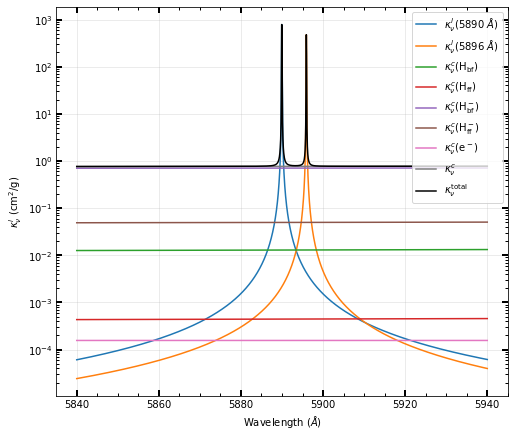

In [27]:
fig, ax = plt.subplots(figsize = (7,6), nrows = 1, ncols = 1)
fig.tight_layout(h_pad=-.5)

    
ax.yaxis.set_ticks_position('both')
ax.xaxis.set_ticks_position('both')
ax.minorticks_on()
ax.grid(True,alpha=.3)

ax.tick_params(direction='in', axis='both',which='minor',length=3,width=1)#,labelsize=8)
ax.tick_params(direction='in',axis='both',which='major',length=6,width=2)#,labelsize=8)

ax.set_yscale("log")

ax.plot(lam_arr,kl[:,0],label=r"$\kappa^l_\nu(5890~\AA)$")
ax.plot(lam_arr,kl[:,1],label=r"$\kappa^l_\nu(5896~\AA)$")

ax.plot(lam_arr,kHbf,label=r"$\kappa^c_\nu(\mathrm{H}_{\mathrm{bf}})$")
ax.plot(lam_arr,kHff,label=r"$\kappa^c_\nu(\mathrm{H}_{\mathrm{ff}})$")
ax.plot(lam_arr,kHnbf,label=r"$\kappa^c_\nu(\mathrm{H}^-_{\mathrm{bf}})$")
ax.plot(lam_arr,kHnff,label=r"$\kappa^c_\nu(\mathrm{H}^-_{\mathrm{ff}})$")
ax.plot(lam_arr,ke*np.ones(np.shape(lam_arr)),label=r"$\kappa^c_\nu(\mathrm{e}^-)$")

ax.plot(lam_arr,k_t, label = r"$\kappa^c_\nu$")

ax.plot(lam_arr,kl[:,0]+kl[:,1]+k_t, label = r"$\kappa_\nu^{\mathrm{total}}$",c="k")

ax.set_ylabel(r"$\kappa^l_\nu~$(cm$^2$/g)")
ax.set_xlabel(r"Wavelength ($\AA$)")

ax.legend()

output_file = "plots/21.pdf"

fig.savefig(output_file,bbox_inches='tight')

In [28]:
astro530.k_cont

<function src.astro530.k_cont(wavelength=<Quantity 5000. Angstrom>, T=<Quantity 5000. K>, Pe=<Quantity 50. dyn / cm2>, Pg=<Quantity 200000. dyn / cm2>, print_bool=False, **kwargs)>

In [29]:
2/partition(species="Na",temp=6420)

0.7719157398471832

In [30]:
1e4/(1+saha_LTE(species="Na",temp=6420*u.K,Pe = Pe_calc(T=6420*u.K,Pg=1.13e5*u.Ba)))

7.114560055391011

In [31]:
k_t

<Quantity [0.76438712, 0.76439263, 0.76439815, ..., 0.77523582, 0.77524117,
           0.77524652] cm2 / g>